# Detector characterization

- [ 1 - Introduction ](#1)
- [ 2 - Packages](#2)
- [ 3 - Data set](#3)
- [ 4 - Sensor Characterization](#4)
  - [ 4.1 Parameter extraction](#4.1)
  - [ 4.2 Calibration](#4.2)

<a name="1"></a>
# 1 - Introduction

This notebook goes through the analysis process used to characterize and QC superconducting sensors for the POLARBEAR-2 (PB-2) telescopes based on measurements performed in our laboratory at UCSD. We have successfully deployed the first two PB-2 telescopes with a full complement of over 15,000 superconducting sensors.

Strict requirements were placed on the thermal and electrical properties and yield of the detectors in order to ensure that PB-2 would achieve it's science goals. The sensors are fabricated on 150 mm silicon wafers with over 1,000 sensors per wafer. In total the PB-2 telescopes required 14 wafers of detectors. In our R&D phase, we fabricated quite a few more than wer

The rest of this section is meant to provide some context by describing the PB-2 experiment and it's science goals and then to give some background on the physics of the superconducting sensors used. Neither of these sections are necessary in order to understand what follows in the analysis procedure, so feel free to skip them if you're not interested. On the other hand, if you are interested, please read on! And if you have questions (particularly any students), please don't hesitate to send me an email. It would help me to clarify my writing as well. 


All that is required is an understanding of Ohm's law and superconductivity (I'll explain that where needed)

Explanation of detector and IV curve. Why we're doing this and what we're trying to do. Published in JLTP

<a name="2"></a>
# 2 - Packages

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression

from utils import load_pkl, convert

<a name="2"></a>
# 3 - Dataset

### Load data

In [3]:
V = np.loadtxt('Voltages.csv', delimiter=',')
I = np.loadtxt('Currents.csv', delimiter=',')
freqs = np.loadtxt('Freqs.csv', delimiter=',')
det_ids = np.loadtxt('IDs.csv', delimiter=',', dtype='str')

### Shape

In [8]:
print('V.shape: ' + str(V.shape))
print('I.shape: ' + str(I.shape))
print('freqs.shape: ' + str(freqs.shape))
print('det_ids.shape: ' + str(det_ids.shape))

ndets = V.shape[0]

V.shape: (2530, 1508)
I.shape: (2530, 1508)
freqs.shape: (2530,)
det_ids.shape: (2530,)


``V`` and ``I`` are arrays of voltage (in volts) and current (in amps). We have data from 2530 detectors and up to 1508 data points for each of them. ``freqs`` is an array of bias frequencies for each detector in Hz. ``det_ids`` is an array of strings that identify each detector

Let's look at the data from a single detector to get a feel for what we're working with. We'll check for NaNs and look at the data

### NaN count

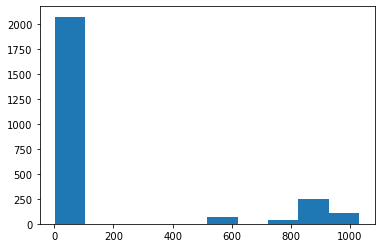

In [9]:
# Count number of NaNs in each row
nan_count = np.isnan(V)
nan_count = np.sum(nan_count, axis=1)

# plot
plt.hist(nan_count)
plt.show()

### I range

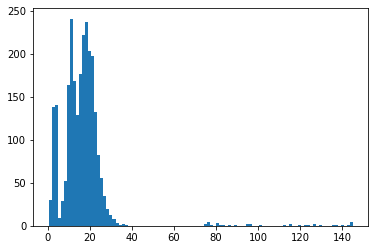

In [10]:
# compare max and min currents
I_max = np.nanmax(I, axis=1)
I_min = np.nanmin(I, axis=1)
I_range = I_max-I_min

plt.hist(I_range, bins=100)
plt.show()

# 4- Sensor Characteriztaion

## 4.1 - Parameter Extraction

First let's find the latching point. We can identify the latching point by find the largest derivative in the data set. Note that Vol[ch] starts high and goes down, so we are looking for a large positive derivative. Also, the spacing along the x-axis is constant, so we can just look at the difference in y-values rather than taking a derivative.

In [12]:
latch_pt = np.nanargmax(np.diff(I), axis=1)

Next let's find the turnaround point and turnaround power

In [35]:
# Create new array I_temp with all points to left of latch_pt set to large values
I_temp = np.full(I.shape, 100.)
for k in range(ndets):
    I_temp[k][:latch_pt[k]] = I[k][:latch_pt[k]]

# turnaround is at minimum of I_temp
turnaround_pt = np.argmin(I_temp, axis=1)

# turnaround power is V*I at turnaround_pt
P = I*V
P_turn = P[turnaround_pt]

In [36]:
P_turn

array([[88.03331805, 87.91820072, 87.80917542, ...,         nan,
                nan,         nan],
       [98.47484107, 98.34412225, 98.21055418, ...,         nan,
                nan,         nan],
       [65.72040559, 65.63507224, 65.55234606, ...,         nan,
                nan,         nan],
       ...,
       [86.3994049 , 86.26637683, 86.17942765, ...,         nan,
                nan,         nan],
       [90.59615449, 90.47326989, 90.35610754, ...,         nan,
                nan,         nan],
       [92.36405928, 92.24332434, 92.13513495, ...,         nan,
                nan,         nan]])

In [34]:
V[:, turnaround_pt].shape

(2530, 2530)

Next let's find the normal resistance

In [17]:
# take the first half of the data before the turnaround to be the region where the detector is fully normal
normal = (turnaround_pt/2).astype(int)

r_n = np.zeros(ndets)
for k in range(ndets):
    
    if normal[k] <= 1:
        continue
    
    x = V[k][:normal[k]]
    y = I[k][:normal[k]]
    
    x = x[~np.isnan(x)].reshape(-1, 1)
    y = y[~np.isnan(y)]
    
    model = LinearRegression()
    model.fit(x, y)
    
    if model.coef_!=0:
        r_n[k] = 1 / model.coef_

## 4.2 - Calibration

<a name="4.1"></a>
## 4.1 - Residual Resistance

Those of you who are familiar with superconductivity may have noticed something odd in the RV plot above - the resistance is nonzero even when the detector is superconducting. A superconductor has zero resistance, so the residual resistance must be a result of some other part of our circuit that is not superconducting. There are several candidates: connectors, capacitor loss, cable inductance, etc. Our goal here will be to: 1) define a model for the residual resistance, 2) measure the model parameters, and 3) calibrate our measurement to give more accurate detector parameters.

### Residual resistance model

We will use the model shown below. Each detector (R_TES) is in series with a unique residual resistance (R_resid). Ohm's law applied to this circuit yields:  

$$V = I (R_{TES}+R_{resid})$$

The voltage that we have stored in ``Vol`` is this voltage. We will be interested in determining the resistance of the detector and the electrical power dissipated in the detector and for both of those, we will need to calculate the voltage on the detector, V_TES. V_tes is related to V by the following:

$V_{TES} = V \frac{R_{TES}}{R_{TES}+R_{res}} = V (1-\frac{R_{res}}{R_{tot}})$

where $R_{tot} = R_{TES}+R_{resid}$ is the total resistance in the model

Our next task, then, is it determine the coefficient of V in that equation, which I'll call CF1. To do that, we'll need to calculate the R_resid for each detector.

### Measuring residual resistance

In region 3 of the IV curve, the detector is fully superconducting and Ohm's law reduces to

$V = IR_{resid}$

We will use linear regression to determine R_resid given our data.

Below we can see that this has identified the latching point

Text(0, 0.5, 'Current [$\\mu$A]')

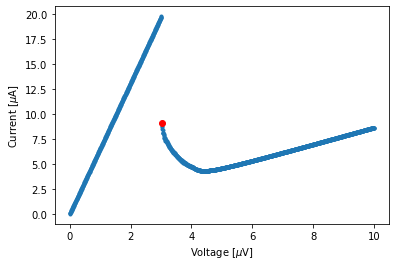

In [13]:
ch = 0
plt.plot(V[ch], I[ch], '.')
plt.plot(V[ch][latch_pt[ch]], I[ch][latch_pt[ch]], 'ro')
plt.xlabel('Voltage [$\mu$V]')
plt.ylabel('Current [$\mu$A]')

In [27]:
# Get residual resistance

r_resid = np.repeat(np.nan, ndets)

for k in range(ndets):
    
    if latch_pt[k] == 0:
        continue
    
    x = V[k][latch_pt[k]+1:]
    y = I[k][latch_pt[k]+1:]
    
    x = x[~np.isnan(x)].reshape(-1, 1)
    y = y[~np.isnan(y)]
    
    model = LinearRegression()
    model.fit(x, y)
    
    if model.coef_!=0:
        r_resid[k] = 1 / model.coef_

Plots below: we can see that the mean is about 0.3 with a fairly tight distribution. Plotting Rres vs frequency is also illuminating. We can see that there is a pretty tight distribution at a given frequency and the mean is rising with frequency. This is not suprising as dielectric loss and cable inductance tend to increase with frequency.

(array([  2.,  21., 536., 822., 438., 114.,  56.,  27.,  28.,  19.,  14.,
         13., 107.,  55.,  29.,  35.,  12.,   5.,   3.]),
 array([0.        , 0.07894737, 0.15789474, 0.23684211, 0.31578947,
        0.39473684, 0.47368421, 0.55263158, 0.63157895, 0.71052632,
        0.78947368, 0.86842105, 0.94736842, 1.02631579, 1.10526316,
        1.18421053, 1.26315789, 1.34210526, 1.42105263, 1.5       ]),
 <BarContainer object of 19 artists>)

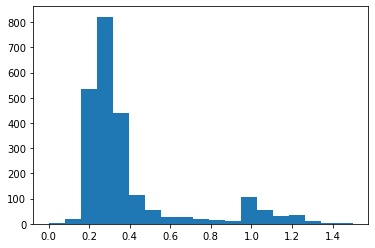

In [31]:
plt.hist(r_resid, bins=np.linspace(0, 1.5, 20));

(0.0, 1.5)

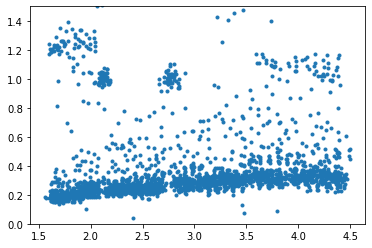

In [36]:
plt.plot(freqs, r_resid, '.')
plt.ylim(0, 1.5);

### Calibrate measurement

First let's calculate our calibration factor Cf1

In [89]:
Rtot = Vol/Cur
Cf1 = 1 - R_res/Rtot

<ipython-input-89-de61b71771a0>:1: RuntimeWarning: invalid value encountered in true_divide
  Rtot = Vol/Cur


There are a few ways to visualize the effect of Cf1. The most intuitive is probably looking at I-V and R-V curves

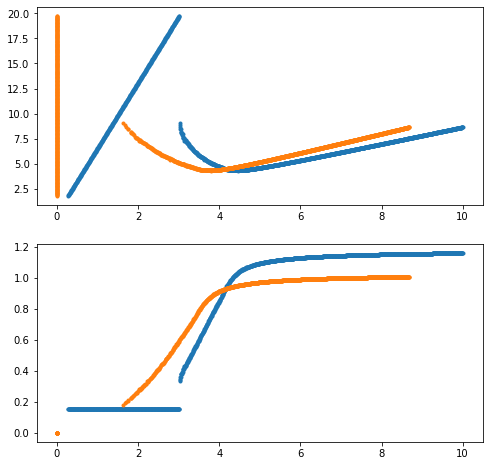

In [99]:
ch = 0
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

ax = axs[0]
ax.plot(Vol[ch], Cur[ch], '.')
ax.plot(Vol[ch]*Cf1[ch], Cur[ch], '.')

ax = axs[1]
ax.plot(Vol[ch], Rtot[ch], '.')
ax.plot(Vol[ch]*Cf1[ch], Rtot[ch]*Cf1[ch], '.')

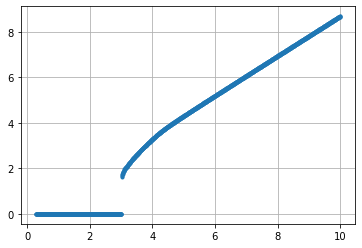

In [87]:
plt.plot(Vol[0], Vol[0]*Cf1[0], '.')
plt.grid()

## 4.2 - Bias Inductance

After removing the residual resistance from our measurement, we find that there is a pretty significant frequency dependence in the normal resistance (put plot of that below). This can be attributed to a parasitic inductance in the part of the circuit that is generating the voltage. The inductance turns out to be of order 1 nH, which is easily explainable by the length of the traces on the PCB and/or stray inductance in the bias resistor SMD. We'll first define the model, then measure it, then apply it.

### Model

The actual voltage applied is given by

$$V_{actual} = I_{in} Z_{bias}$$

where $$Z_{bias}= R_{bias} + i \omega_{bias} L_{bias}$$

Before we even got the data for V, an assumption had already been made that $L_{bias}=0$. Assuming we have some value of $L_{bias}$ in mind, we can fix this with the following:

``V[ch] = V[ch] * np.absolute(Z_bias[k])/R_bias[k]``

We take an asbolute value because Z_bias is complex and we only are interested in the amplitude of V. Since $|Z_{bias}| \geq R_{bias}$, this results in an incrase to V. And since $|Z_{bias}|$ increases with frequency, V also increases with frequency.

### Measuring Lbias

First we'll assume the Rn is uniform across the wafer with some random variation. We will then assume that any frequency dependence is attributable to our readout circuit and then use that to find a value of Lbias. We should ask ourselves: is there any other way to get frequency dependence? Does frequency correlate with something else, like position on the wafer?

In [39]:
#Find turnaround
#temporarily set all points to the left of latching point to large values
I_temp = np.full(I.shape, 100.)

for k in range(ndets):
    I_temp[k][:latch_pt[k]] = I[k][:latch_pt[k]]

turnaround_pt = np.argmin(I_temp, axis=1)

In [42]:
# fit normal resistance
# take the first half of the data before the turnaround to be the region where the detector is fully normal
normal = (turnaround_pt/2).astype(int)

r_tot = np.zeros(ndets)

for k in range(ndets):
    
    if normal[k] <= 1:
        continue
    
    x = V[k][:normal[k]]
    y = I[k][:normal[k]]
    
    x = x[~np.isnan(x)].reshape(-1, 1)
    y = y[~np.isnan(y)]
    
    model = LinearRegression()
    model.fit(x, y)
    
    if model.coef_!=0:
        r_tot[k] = 1 / model.coef_

(0.0, 2.0)

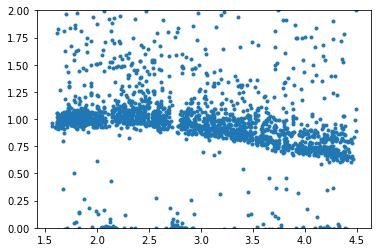

In [45]:
# make plot of Rn vs bias frequency

plt.plot(freqs, r_tot-r_resid, '.')
plt.ylim(0, 2)

The detectors IDs are strings of numbers. They are important now. Detectors who share the first three sets of numbers also share a common bias resistor. Let's plot one set of those detectors

In [48]:
combs = []
for k in range(len(det_ids)):
    if det_ids[k][:8] not in combs:
        combs.append(det_ids[k][:8])


# Older stuff

Next we're going to apply to calibrations to the data set. I'll motivate them each and then apply the calibration.

First we need to deal with the residual resistance. We will model this as a unique resistance in series with each detector. The values in Vol are voltages applied accross the series combination of a detector and a residual resistance. 

The TES resistance is given by: 

$R_{TES} = R_{tot}-R_{res}$

The voltage across the TES is related to Vol by the following:

$V_{TES} = V \frac{R_{TES}}{R_{TES}+R_{res}} = V (1-\frac{R_{res}}{R_{tot}})$

We'll define the coefficient in this equation as calibration factor 1 (cf1)

For our next calculations, we will want to estimate the voltage across just the detector. Since we have fit for the residual resistance and we can get the total resistance by dividing Vol by Cur, we can do this math. Note that the current through the detector does not need to be calibrated because it is the same current flowing through both elements

In [33]:
R_tot = Vol/Cur
Cf1 = 1 - R_res / R_tot

<ipython-input-33-a54db45ad4a1>:1: RuntimeWarning: invalid value encountered in true_divide
  R_tot = Vol/Cur


Let's take a look at some data with this calibration applied:

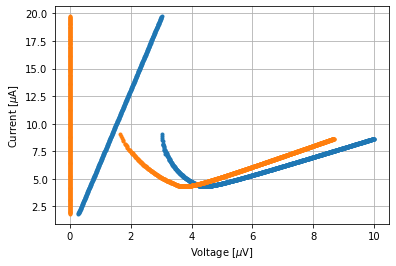

In [38]:
plt.plot(Vol[0], Cur[0], '.')
plt.plot(Vol[0]*Cf1[0], Cur[0], '.')
plt.xlabel('Voltage [$\mu$V]')
plt.ylabel('Current [$\mu$A]')

Text(0, 0.5, 'Resistance [$\\Omega$]')

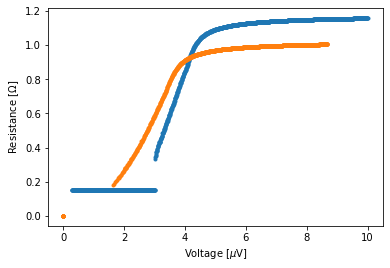

In [41]:
plt.plot(Vol[0], Vol[0]/Cur[0], '.')
plt.plot(Vol[0]*Cf1[0], Vol[0]*Cf1[0]/Cur[0], '.')
plt.xlabel('Voltage [$\mu$V]')
plt.ylabel('Resistance [$\Omega$]')

Now we'll move onto the next calibration

In [26]:
Vol_tes = Vol * (R_tot-R_res)

<ipython-input-26-842951759207>:1: RuntimeWarning: invalid value encountered in multiply
  Vol_tes = Vol * (R_tot-R_res)


In [27]:
R_tot-R_res

array([[1.04334461],
       [1.2928935 ],
       [1.08674091],
       ...,
       [0.62925168],
       [0.60960801],
       [0.60877794]])

(array([571.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,
          0.,   1.,   1.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   2.,
          8.,  54., 119., 117., 101., 143., 317., 375., 344., 199., 113.,
         67.,  44.,  35.,  32.,  24.,  21.,  13.,  14.,   9.,  18.,  20.,
          5.,   9.,  14.,  14.,   7.]),
 array([0.        , 0.04081633, 0.08163265, 0.12244898, 0.16326531,
        0.20408163, 0.24489796, 0.28571429, 0.32653061, 0.36734694,
        0.40816327, 0.44897959, 0.48979592, 0.53061224, 0.57142857,
        0.6122449 , 0.65306122, 0.69387755, 0.73469388, 0.7755102 ,
        0.81632653, 0.85714286, 0.89795918, 0.93877551, 0.97959184,
        1.02040816, 1.06122449, 1.10204082, 1.14285714, 1.18367347,
        1.2244898 , 1.26530612, 1.30612245, 1.34693878, 1.3877551 ,
        1.42857143, 1.46938776, 1.51020408, 1.55102041, 1.59183673,
        1.63265306, 1.67346939, 1.71428571, 1.75510204, 1.79591837,
        1.83673469, 1.87755102, 1.91836735, 1.959183

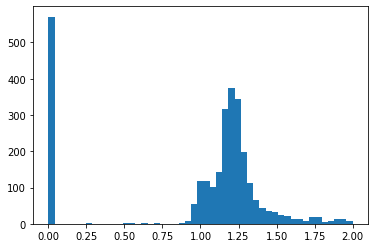

In [83]:
plt.hist(R_n, bins=np.linspace(0, 2))

(0.5, 1.8)

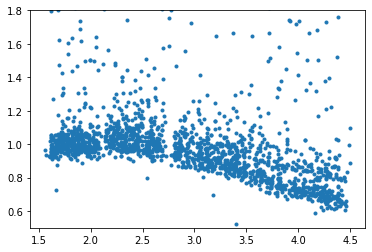

In [24]:
plt.plot(frq/1e6, (R_n-R_res), '.')
plt.ylim(0.5, 1.8)